# Naive Bayes

Se muestra un ejemplo de clasificación binaria con los datos de `german-credit`.

Importación de librerías y carga de datos

In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.naive_bayes import BernoulliNB, GaussianNB 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix

# Suprimir todas las advertencias
warnings.simplefilter("ignore")

datos = pd.read_csv("../datos/credit_g.csv")

datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

Se hace una conversión a variables categóricas y se convierte a numérica (1, 0) la variable target:
- Si el préstamo es default, se convierte a 1. En caso, contrario es 0

In [3]:
# Pasamos las variables a categóricas
datos['checking_status'] = datos['checking_status'].astype('category')
datos['credit_history'] = datos['credit_history'].astype('category')
datos['purpose'] = datos['purpose'].astype('category')
datos['savings_status'] = datos['savings_status'].astype('category')
datos['employment'] = datos['employment'].astype('category')
datos['personal_status'] = datos['personal_status'].astype('category')
datos['other_parties'] = datos['other_parties'].astype('category')
datos['property_magnitude'] = datos['property_magnitude'].astype('category')
datos['other_payment_plans'] = datos['other_payment_plans'].astype('category')
datos['housing'] = datos['housing'].astype('category')
datos['job'] = datos['job'].astype('category')
datos['property_magnitude'] = datos['property_magnitude'].astype('category')
datos['own_telephone'] = datos['own_telephone'].astype('category')
datos['foreign_worker'] = datos['foreign_worker'].astype('category')
datos['class'] = datos['class'].astype('category')

In [4]:
# La variable class es una variable reservada en diferentes módulos de Python -> reemplazar por por target
datos.rename(columns={'class': 'target'}, inplace=True)
datos['target']=np.where(datos['target']=='good', 0, 1) # cambio en la codificación por sencillez en el preprocesado

Una vez esto, tiene lugar la definición de la muestra:
- Conversión a variables dummy de las variables categóricas (excluyendo un nivel para evitar multicolinealidad)
- Partición de la muestra (train y test)
- Estandarización de los datos (sobre la muestra de entrenamiento y aplicación de resultados sobre muestra de test)
- Aplicación de validación cruzada

In [5]:
# Definición de la muestra de trabajo
datos_entrada = datos.drop('target', axis=1) # Datos de entrada
datos_entrada = pd.get_dummies(datos_entrada, drop_first=True, dtype=int) #conversión a variables dummy

target = datos["target"] # muestra del target

In [6]:
# Partición de la muestra

test_size = 0.3 # muestra para el test 
seed = 222 # semilla

X_train, X_test, y_train, y_test = train_test_split(
    datos_entrada, target, test_size=test_size, random_state=seed, stratify=target
)

# Estandarización de la muestra
esc = StandardScaler().fit(X_train) # valores media y std de los datos de train

# aplicación a los datos de train y test
X_train_esc = esc.transform(X_train)
X_test_esc = esc.transform(X_test)

# Validación cruczada
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=seed)

#### Bernoulli Naive Bayes

Obtención de hiperparámetros

In [7]:
bernoulli_nb=BernoulliNB(force_alpha=False)

grid=[{'alpha': list(np.arange(0.05, 1, 0.1)), 'binarize': [0.3, 0.1, 0.0]}]

In [8]:
# Definición del modelo con hiperparámetros
gs_bernoulli_nb = GridSearchCV(
    estimator=bernoulli_nb, param_grid=grid, scoring='accuracy', cv=cv, n_jobs=1, return_train_score=False
)
gs_bernoulli_nb = gs_bernoulli_nb.fit(X_train, y_train)

print(f'Naive-Bayes (Bernoulli) (parámetros): {gs_bernoulli_nb.best_params_}') # parámetros del modelo final

bernoulli_nb = gs_bernoulli_nb.best_estimator_ # modelo final

Naive-Bayes (Bernoulli) (parámetros): {'alpha': 0.35000000000000003, 'binarize': 0.3}


Obtención de probabilidades de cada clase

In [9]:
# Resultados importantes de estos algoritmos (acceso dentro del objeto del modelo)
print(bernoulli_nb.class_log_prior_)  # logaritmo de la probabilidad de cada clase
print(bernoulli_nb.class_log_prior_)  # logaritmo de la probabilidad de cada clase
bernoulli_nb.feature_log_prob_ # logaritmo de la probabilidad de la variable dada la clase (P(Xi|Y)

[-0.35667494 -1.2039728 ]
[-0.35667494 -1.2039728 ]


array([[-7.13521258e-04, -7.13521258e-04, -7.13521258e-04,
        -7.13521258e-04, -7.13521258e-04, -7.13521258e-04,
        -7.13521258e-04, -1.45656902e+00, -1.62784555e+00,
        -2.63053455e+00, -1.07574552e+00, -2.49824155e+00,
        -6.41517688e-01, -3.85884642e+00, -1.62784555e+00,
        -2.06306927e+00, -2.40372023e+00, -3.00330109e+00,
        -1.72590991e+00, -4.72565710e+00, -1.19625860e+00,
        -3.96045660e+00, -4.07357140e+00, -2.54907842e+00,
        -2.81654040e+00, -5.96115527e-01, -2.75061868e+00,
        -1.62784555e+00, -1.92823560e+00, -1.28796893e+00,
        -2.85120591e+00, -3.46471747e+00, -2.25716801e+00,
        -5.81428280e-01, -2.78303643e+00, -9.02587657e-02,
        -2.14666010e+00, -1.15015231e+00, -1.12472990e+00,
        -1.64306690e-01, -3.28620337e+00, -2.89517871e-01,
        -1.80944085e+00, -3.76661520e+00, -1.54808231e+00,
        -4.67845780e-01, -8.75998733e-01, -4.23558447e-02],
       [-1.66251077e-03, -1.66251077e-03, -1.66251077e-

Predicciones para la muestra de entrenamiento y test (curva roc y accuracy)

Accuracy
------------------------------
Entrenamiento (cv): 0.745
Test: 0.70667


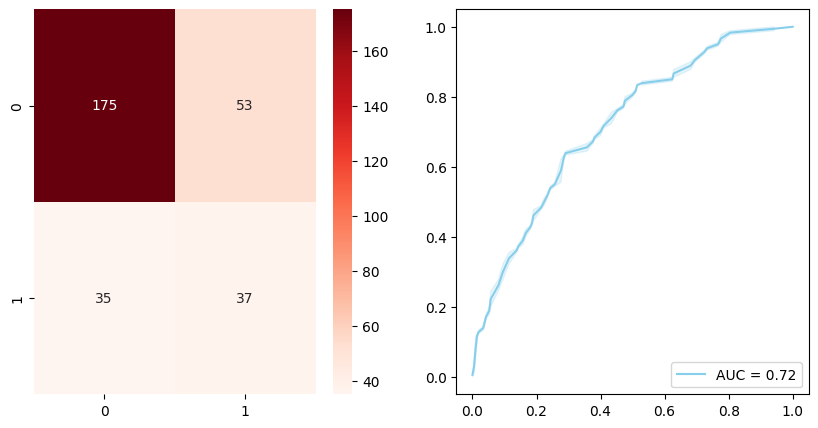

In [10]:
# Predicciones muestra entrenamiento y test

preds_train = bernoulli_nb.predict(X_train)
preds_test = bernoulli_nb.predict(X_test)

# Cálculo métricas bondad de ajuste 
print('Accuracy')
print('------------------------------')
print(f'Entrenamiento (cv): {round(gs_bernoulli_nb.best_score_,5)}')
accuracy_test = accuracy_score(y_test, preds_test)
print(f'Test: {round(accuracy_test,5)}')

# AUC - test y curva roc (final
y_pred_test = bernoulli_nb.predict_proba(X_test)
fp_rate_test, tp_rate_test, thresholds = roc_curve(y_test, y_pred_test[:,1])
auc_test = auc(fp_rate_test, tp_rate_test)

# Bondad de ajuste: matriz de confusión y curva roc para los datos de test

f, axes = plt.subplots(1, 2, figsize=(10,5))

sns.heatmap(confusion_matrix(preds_test, y_test), annot = True, cmap = plt.cm.Reds, fmt='.0f', ax=axes[0]) # matriz de confusión
sns.lineplot(x=fp_rate_test, y=tp_rate_test, color='skyblue', label='AUC = %0.2f' % auc_test, ax=axes[1]) # curva roc

plt.legend(loc="lower right")
plt.show()


#### Gaussian Naive Bayes

Como en el caso anterior, se parte de una serie de hiperparámetros, se realiza el entrenamiento del modelo y sus predicciones. Finalmente, se analiza el accuracy y la curva roc como de métricas de bondad de ajuste del clasificador

Naive-Bayes (Bernoulli) (parámetros): {'var_smoothing': 0.08}
Accuracy
------------------------------
Entrenamiento (cv):, 0.70571
Test: 0.70667


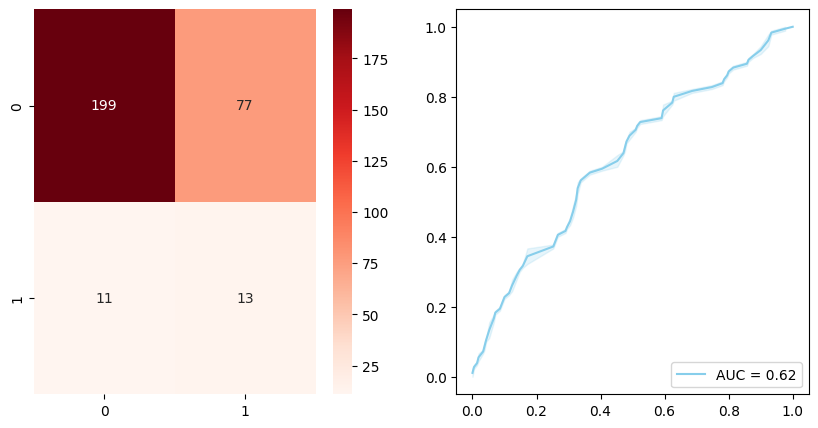

In [11]:
gaussian_nb = GaussianNB()
grid=[{'var_smoothing': list(np.arange(0,0.1, 0.02))}]

# Definición del modelo con hiperparámetros
gs_gaussian_nb=GridSearchCV(
    estimator=gaussian_nb, param_grid=grid, scoring='accuracy', cv=cv, n_jobs=1, return_train_score=False
)

gs_gaussian_nb = gs_gaussian_nb.fit(X_train, y_train)
print('Naive-Bayes (Bernoulli) (parámetros):', gs_gaussian_nb.best_params_) 

#parámetros del modelo final
gaussian_nb = gs_gaussian_nb.best_estimator_ #modelo final

# predicciones muestra entrenamiento y test

preds_train = gaussian_nb.predict(X_train)
preds_test = gaussian_nb.predict(X_test)

# Cálculo métricas bondad de ajuste 

print('Accuracy')
print('------------------------------')
print(f'Entrenamiento (cv):, {round(gs_gaussian_nb.best_score_,5)}')
accuracy_test = accuracy_score(y_test, preds_test)
print('Test:', round(accuracy_test,5))

#AUC - test y curva roc (final)

y_pred_test = gaussian_nb.predict_proba(X_test)
fp_rate_test, tp_rate_test, thresholds = roc_curve(y_test, y_pred_test[:,1])
auc_test = auc(fp_rate_test, tp_rate_test)

# Bondad de ajuste: matriz de confusión y curva roc para los datos de test

f, axes = plt.subplots(1, 2, figsize=(10,5))

sns.heatmap(confusion_matrix(preds_test, y_test), annot = True, cmap = plt.cm.Reds, fmt='.0f', ax=axes[0]) # matriz de confusión
sns.lineplot(x=fp_rate_test, y=tp_rate_test, color='skyblue', label='AUC = %0.2f' % auc_test, ax=axes[1]) # curva roc

plt.legend(loc="lower right")
plt.show()
